In [5]:
from scipy.io import loadmat
from matplotlib import pyplot as plt


from scipy.misc import imresize
from __future__ import print_function
from scipy.misc import imsave
import numpy as np
import time
import os
import h5py

from keras.models import Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.optimizers import SGD

In [6]:
mat = loadmat('/media/perceptron/54B4F78779120A69/text-data/jaderberg-eccv2014_textspotting/data/case_insensitive-train_v7.mat')
mat.keys()

dict_keys(['gt', '__globals__', '__header__', '__version__'])

In [7]:
# gt = mat['gt']

# print ((gt.shape, type(gt)))
# temp_0 = gt[0]
# print ((temp_0.shape, type(temp_0)))
# temp_1 = temp[0]
# print ((temp_1.shape, type(temp_1)))
# temp_2_a = temp_1[0]
# temp_2_b = temp_1[1]

# print ((temp_2_a.shape, type(temp_2_a)))
# print ((temp_2_b.shape, type(temp_2_b)))
# temp_2_b_0 = temp_2_b[0,0]
# print (temp_2_b_0.shape)
# temp_2_b_0_0 = temp_2_b_0[0,0]
# print (temp_2_b_0_0.shape)
images =  mat['gt'][0][0][1]# gt = mat['gt']

In [13]:
images[0][0][0][0].shape

(24, 24)

In [23]:
X = np.zeros((185639, 24, 24), dtype = np.uint8)
y = np.ones((185639))
count = 0
for index_c, value_c in enumerate(images[0,:]):
    for index_i, value_i in enumerate(value_c[0,:]):
        X[count, :, :] = value_i
        count += 1

In [24]:
count

185639

In [25]:
y.shape

(185639,)

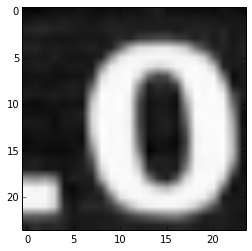

In [30]:
%matplotlib inline
img  = X[100, :, :]#.mean(axis = 2)
plt.imshow(img, cmap = 'Greys_r')

In [27]:
cd /media/perceptron/54B4F78779120A69/text-data/jaderberg-eccv2014_textspotting/data

/media/perceptron/54B4F78779120A69/text-data/jaderberg-eccv2014_textspotting/data


In [18]:
import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

In [19]:
x_cifar, _ = load_CIFAR_batch('/home/perceptron/cape_coalwood/text/cifar-10-batches-py/data_batch_1')
resized_images = np.zeros((10000, 24, 24))
for i in range(resized_images.shape[0]):
    img  = x_cifar[i, :, :, :].mean(axis = 2)
    img = imresize(img, size = (24, 24))
    resized_images[i, :, :] = img

In [20]:
X = np.concatenate((X, resized_images), axis = 0)

In [21]:
X.shape

(195639, 24, 24)

In [24]:
resize_label = np.ones((10000))
y = np.concatenate((y, resize_label), axis= 0)

In [25]:
y.shape

(195639,)

In [28]:
with h5py.File('train_text_non_text_pos.h5','w') as hf:
    hf.create_dataset('X', data=X)
    hf.create_dataset('y', data=y)

In [29]:
# Test score the experiment
with h5py.File('train_text_non_text_pos.h5','r') as hf:
    print('List of arrays in this file: \n', hf.keys())
    data = hf.get('X')
    X = np.array(data)
    data = hf.get('y')
    y = np.array(data)

List of arrays in this file: 
 KeysView(<HDF5 file "train_text_non_text_pos.h5" (mode r)>)


In [5]:
%cd /media/perceptron/54B4F78779120A69/text-data/jaderberg-eccv2014_textspotting/data/
with h5py.File('test_case_insesitive.h5','r') as hf:
    print('List of arrays in this file: \n', hf.keys())

/media/perceptron/54B4F78779120A69/text-data/jaderberg-eccv2014_textspotting/data
List of arrays in this file: 


 [u'X', u'y']


In [31]:
%cd /home/perceptron/cape_coalwood/text/text-non-text/deep_text/
batch_size = 32
nb_epoch = 50
img_rows, img_cols = 24, 24
nb_classes = 37

weights_path = 'weight.hdf5'
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
#     x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# build the VGG16 network
model = Sequential()

model.add(Convolution2D(128, 3, 3, border_mode='same', input_shape=(1, img_rows, img_cols)))

first_layer = model.layers[-1]
input_img = first_layer.input

model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.75))

model.add(Convolution2D(256, 3, 3))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(256, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(37))
model.add(Activation('softmax'))
print('Model loaded.')

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.summary()

/home/perceptron/cape_coalwood/text/text-non-text/deep_text
Model loaded.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_16 (Convolution2D) (None, 128, 24, 24)   1280        convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
activation_19 (Activation)       (None, 128, 24, 24)   0           convolution2d_16[0][0]           


____________________________________________________________________________________________________
convolution2d_17 (Convolution2D) (None, 128, 24, 24)   147584      activation_19[0][0]              
____________________________________________________________________________________________________
activation_20 (Activation)       (None, 128, 24, 24)   0           convolution2d_17[0][0]           


____________________________________________________________________________________________________
convolution2d_18 (Convolution2D) (None, 128, 24, 24)   147584      activation_20[0][0]              
____________________________________________________________________________________________________
activation_21 (Activation)       (None, 128, 24, 24)   0           convolution2d_18[0][0]           
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 128, 12, 12)   0           activation_21[0][0]              
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, 128, 12, 12)   0           maxpooling2d_7[0][0]             
____________________________________________________________________________________________________
convolution2d_19 (Convolution2D) (None, 256, 10, 10)   295168      dropout_10[0][0]       


____________________________________________________________________________________________________
activation_22 (Activation)       (None, 256, 10, 10)   0           convolution2d_19[0][0]           
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 256, 10, 10)   0           activation_22[0][0]              
____________________________________________________________________________________________________
convolution2d_20 (Convolution2D) (None, 256, 8, 8)     590080      dropout_11[0][0]                 


____________________________________________________________________________________________________
activation_23 (Activation)       (None, 256, 8, 8)     0           convolution2d_20[0][0]           
____________________________________________________________________________________________________
maxpooling2d_8 (MaxPooling2D)    (None, 256, 4, 4)     0           activation_23[0][0]              
____________________________________________________________________________________________________
dropout_12 (Dropout)             (None, 256, 4, 4)     0           maxpooling2d_8[0][0]             
____________________________________________________________________________________________________
flatten_4 (Flatten)              (None, 4096)          0           dropout_12[0][0]                 
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 37)            151589      flatten_4[0][0]        


____________________________________________________________________________________________________
activation_24 (Activation)       (None, 37)            0           dense_4[0][0]                    
Total params: 1333285
____________________________________________________________________________________________________


Processing filter 0
(1, 24, 24)

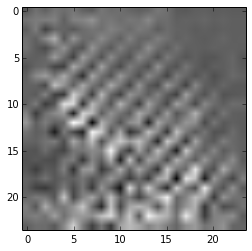

In [50]:
from keras import backend as K

filter_index = 0
print('Processing filter %d' % filter_index)
layer_name  = 'convolution2d_20'
layer_dict = dict([(layer.name, layer) for layer in model.layers])
# we build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, 13, :, :])

# we compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img,  K.learning_phase()], [loss, grads])
input_img_data = np.random.random((1, 1, 24, 24)) * 20 + 128.

# run gradient ascent for 20 steps
for i in range(500):
    loss_value, grads_value = iterate([input_img_data, 0])
    input_img_data += grads_value * 1
#     print (loss_value)
    
img = input_img_data[0]
img = deprocess_image(img)
print (img.shape)
# imsave('%s_filter_%d.png' % (layer_name, filter_index), img[0,:,:])
plt.imshow(img[0,:,:], cmap = 'Greys_r')

In [27]:
%matplotlib inline